In [2]:
import pandas as pd
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import zipfile
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import random
import numpy as np
import time as t

## Extract images from zip file

In [3]:
# Path to the ZIP file
zip_file_path = "qr_images.zip"

# Extract the contents of the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall("qr_images_extracted")

# List all files in the extracted folder
extracted_files = os.listdir("qr_images_extracted/content/qr_images")

# Filter out files with the desired format
matching_files = [filename for filename in extracted_files if filename.startswith("qr_code_") and filename.endswith(".png")]

# Check how many images there are and if all have the desired format
total_images = len(extracted_files)
matching_format = len(matching_files) == total_images

print(f"Total number of images: {total_images}")
print(f"All images have the desired format: {matching_format}")


Total number of images: 11430
All images have the desired format: True


Check if there are any duplicates.

In [ ]:
duplicate_files_indices = {}

# Iterate through the list of filenames
for index, filename in enumerate(extracted_files):
    # If the filename already exists in the dictionary, add the current index to the list of indices
    if filename in duplicate_files_indices:
        duplicate_files_indices[filename].append(index)
    else:
        # If the filename is encountered for the first time, initialize a list with the current index
        duplicate_files_indices[filename] = [index]
# Filter out filenames with more than one index (indicating duplicates)
duplicate_filenames = {filename: indices for filename, indices in duplicate_files_indices.items() if len(indices) > 1}

# Print the indices of files with the same name
if duplicate_filenames:
    print("Files with the same name:")
    for filename, indices in duplicate_filenames.items():
        print(f"Filename: {filename}, Indices: {indices}")
else:
    print("No files with the same name.")

No files with the same name.


## Preprocessing of the images for the CNN

In [4]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None):
        self.data_dir = data_dir
        self.labels = labels
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, f"qr_code_{idx}.png") for idx in range(len(labels))]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = os.path.join(self.data_dir, f"qr_code_{idx}.png")
        image = datasets.folder.default_loader(img_name)
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label



### Convert the images to Pytorch tensors and split the data

In [5]:
random_seed = 123
torch.manual_seed(random_seed)


# Define the path to the folder containing images
data_dir = "qr_images_extracted/content/qr_images/"
#/content/qr_images_extracted/content/qr_images/qr_code_0.png
# Load your data to extract target
df = pd.read_csv("df_lexical_unscaled.csv")

# Extract labels from the 'target' column
labels = df.iloc[:, -1].tolist()

# Define transformations to apply to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a fixed size
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),           # Convert images to PyTorch tensors
])

# Create the custom dataset
custom_dataset = CustomDataset(data_dir, labels, transform=transform)

# Split the dataset into train and test sets
train_size = int(0.8 * len(custom_dataset))  # 80% of the data for training
train_train_size = int(0.8 * train_size)
train_validation_size =train_size -train_train_size
test_size = len(custom_dataset) - train_size  # Remaining 20% for testing

train_set, test_set = torch.utils.data.random_split(custom_dataset, [train_size, test_size])
train_train, train_val = torch.utils.data.random_split(train_set, [train_train_size, train_validation_size])


# Update the creation of train_loader and test_loader
train_loader = torch.utils.data.DataLoader(train_set.dataset, batch_size=32, shuffle=True)
train_train_loader = torch.utils.data.DataLoader(train_train.dataset, batch_size=32, shuffle=True)
train_val_loader = torch.utils.data.DataLoader(train_val.dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set.dataset, batch_size=32, shuffle=False)


In [6]:
traindata = iter(train_loader)

images, labels = next(traindata)

print(images[1].shape)

torch.Size([1, 224, 224])


In [6]:
import copy
print(f'The number of qr codes in the train set is :{len(train_loader.dataset)}, therefore we will take {0.8*len(train_loader.dataset)} images for training and the rest of them for validate')
#valid_loader = copy.deepcopy(train_loader)  # Creates a copy of the object



The number of qr codes in the train set is :11430, therefore we will take 9144.0 images for training and the rest of them for validate


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 2)  # 2 classes: legitimate or phishing

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 128 * 28 * 28)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


    def predict(self, image_path, device):
        # Define the transformation to preprocess the image
        transform = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize((28, 28)),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

        # Load and preprocess the image
        image = Image.open(image_path)
        image = transform(image).unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Set model to evaluation mode
        self.eval()

        # Make prediction
        with torch.no_grad():
            outputs = self.forward(image)
            _, predicted = torch.max(outputs, 1)

        return predicted.item()
# Initialize the model
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [8]:
# Set seed for Python random module
random_seed = 123

# Set seed for NumPy
random.seed(random_seed)

# Set seed for PyTorch
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Initialize lists to store loss and accuracy values
train_losses = []
val_losses = []
accuracies = []

# Define number of epochs
num_epochs = 15

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
  print('The cuda is available')
model.to(device)

start = t.time()
best_val_accuracy = 0
# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    running_loss = 0.0
    for images, labels in train_train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * images.size(0)

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_train_loader.dataset)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)

    end = t.time()
    training_time = end-start

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in train_val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss
    val_loss /= len(train_val_loader.dataset)

    # Calculate accuracy
    accuracy = correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Check if current validation accuracy is better than the previous best
    if accuracy > best_val_accuracy:
        best_val_accuracy = accuracy
        # Save the model
        model_path = 'simple_cnn_model.pkl'
        torch.save(model.state_dict(),model_path)

    # Append loss and accuracy values to lists
    val_losses.append(val_loss)
    accuracies.append(accuracy)
print("Training finished.")

The cuda is available
Epoch [1/15], Train Loss: 0.6738
Epoch [1/15], Validation Loss: 0.6519, Accuracy: 0.5866
Epoch [2/15], Train Loss: 0.5728
Epoch [2/15], Validation Loss: 0.4959, Accuracy: 0.7524
Epoch [3/15], Train Loss: 0.4987
Epoch [3/15], Validation Loss: 0.4265, Accuracy: 0.8071
Epoch [4/15], Train Loss: 0.4155
Epoch [4/15], Validation Loss: 0.3299, Accuracy: 0.8622
Epoch [5/15], Train Loss: 0.3272
Epoch [5/15], Validation Loss: 0.2232, Accuracy: 0.9112
Epoch [6/15], Train Loss: 0.2273
Epoch [6/15], Validation Loss: 0.1766, Accuracy: 0.9455
Epoch [7/15], Train Loss: 0.1580
Epoch [7/15], Validation Loss: 0.0876, Accuracy: 0.9694
Epoch [8/15], Train Loss: 0.0879
Epoch [8/15], Validation Loss: 0.0542, Accuracy: 0.9824
Epoch [9/15], Train Loss: 0.0534
Epoch [9/15], Validation Loss: 0.0571, Accuracy: 0.9813
Epoch [10/15], Train Loss: 0.0556
Epoch [10/15], Validation Loss: 0.0287, Accuracy: 0.9931
Epoch [11/15], Train Loss: 0.0374
Epoch [11/15], Validation Loss: 0.0194, Accuracy: 0.

In [9]:
print('Training execution time',round(training_time,2), 'seconds, so',round(training_time/60, 2) ,'minutes.')


Training execution time 980.17 seconds, so 16.34 minutes.


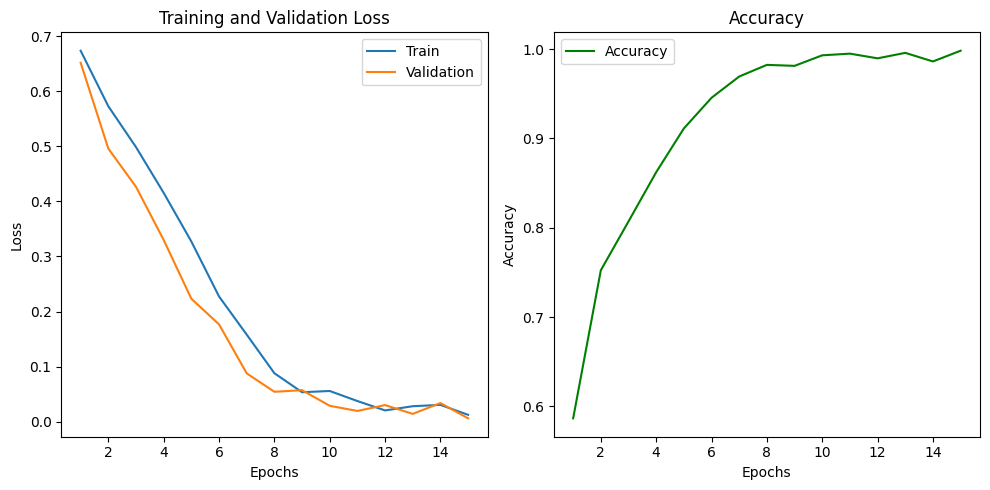

In [10]:
# Plotting
plt.figure(figsize=(10, 5))

# Plot training and validation losses
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), accuracies, label='Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [11]:
random.seed(random_seed)

# Set model to evaluation mode
model.eval()

# Initialize variables for accuracy calculation
correct = 0
total = 0

# Initialize lists to store predictions and ground truth labels
all_predictions = []
all_labels = []

# Disable gradient computation for inference
with torch.no_grad():
    for images, labels in test_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predictions
        _, predicted = torch.max(outputs.data, 1)

        # Update total count of samples
        total += labels.size(0)

        # Update count of correct predictions
        correct += (predicted == labels).sum().item()

        # Store predictions and ground truth labels
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9419


In [12]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate precision, recall, and F1-score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Accuracy:{accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")


Accuracy:0.9419, Precision: 0.9419, Recall: 0.9419, F1-score: 0.9419


In [13]:
# Assuming train_train_loader and train_val_loader are DataLoaders
full_train_dataset = torch.utils.data.ConcatDataset([train_train_loader.dataset, train_val_loader.dataset])
full_train_loader = torch.utils.data.DataLoader(full_train_dataset, batch_size=32, shuffle=True)


In [15]:
# Initialize lists to store loss and accuracy values
train_losses = []

# Define number of epochs
num_epochs = 15

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    print('The GPU is available')
model.to(device)

start = t.time()

# Training loop
for epoch in range(num_epochs):
    # Set model to training mode
    model.train()
    running_loss = 0.0
    for images, labels in full_train_loader:
        # Move data to GPU if available
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * images.size(0)

    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(full_train_loader.dataset)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")
    train_losses.append(epoch_loss)

end = t.time()
training_time = end - start
print(f"Training finished in {training_time:.2f} seconds.")

# Save the model
model_path = 'simple_cnn_model_complete.pkl'
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")


The GPU is available
Epoch [1/15], Train Loss: 0.0179
Epoch [2/15], Train Loss: 0.0146
Epoch [3/15], Train Loss: 0.0068
Epoch [4/15], Train Loss: 0.0257
Epoch [5/15], Train Loss: 0.0146
Epoch [6/15], Train Loss: 0.0048
Epoch [7/15], Train Loss: 0.0173
Epoch [8/15], Train Loss: 0.0116
Epoch [9/15], Train Loss: 0.0102
Epoch [10/15], Train Loss: 0.0039
Epoch [11/15], Train Loss: 0.0169
Epoch [12/15], Train Loss: 0.0045
Epoch [13/15], Train Loss: 0.0002
Epoch [14/15], Train Loss: 0.0001
Epoch [15/15], Train Loss: 0.0001
Training finished in 1166.67 seconds.
Model saved to simple_cnn_model_complete.pkl
